In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch_geometric as pyg
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from utils import *

from dataset import *

np.set_printoptions(threshold=np.inf)
torch.set_printoptions(profile="full")


/Users/rcheeter/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rcheeter/anaconda3/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/rcheeter/anaconda3/lib/python3.10/site-packages/libpyg.so, 6): Symbol not found: __ZN2at27getStepCallbacksUnlessEmptyENS_11RecordScopeE
  Referenced from: /Users/rcheeter/anaconda3/lib/python3.10/site-packages/libpyg.so
  Expected in: /Users/rcheeter/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/rcheeter/anaconda3/lib/python3.10/site-packages/libpyg.so
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


In [ ]:
import random

data_dir = "data/processed"
working_dir = os.getcwd()

data_path = "data/processed/data_paths.csv"

# ignore split
graph_path_list = make_dataset(data_path, data_dir, working_dir, data_type='data', radius_ncov=10, split=[0.8, 0.0, 0.2], num_process=4)

random.shuffle(graph_path_list)

train_graph_path_list = graph_path_list[:40]
test_graph_path_list = graph_path_list[40:]

train_list = []
for train_path in train_graph_path_list:
    train_list.append(torch.load(train_path))

test_list = []
for test_path in test_graph_path_list:
    test_list.append(torch.load(train_path))

data_example = train_list[0]


In [ ]:
train_loader = pyg.loader.DataLoader(train_list, batch_size=2, shuffle=False)
test_loader = pyg.loader.DataLoader(test_list, batch_size=2, shuffle=False)

LOOK AT

https://github.com/pyg-team/pytorch_geometric/issues/2677

https://github.com/pyg-team/pytorch_geometric/discussions/7877

https://github.com/pyg-team/pytorch_geometric/blob/master/examples/ppi.py

https://github.com/pyg-team/pytorch_geometric/discussions/7877

In [2]:
# data_path = "/Users/rcheeter/GitHub/druggabilityclassifer/dc_data_processed/dc_graph_TYPE-data_LEN-20_SPLIT-80-00-20.pyg"
# dataset = torch.load(data_path)

# print(dataset)

# # look into better ways to circumvent combining the proteing graphs into one large graph object --> improved neighbor loader?

# # train_sampler = pyg.loader.ImbalancedSampler(dataset.y, input_nodes=dataset.train_mask)
# # # train_loader = pyg.loader.NeighborLoader(dataset, input_nodes=dataset.train_mask, batch_size=1000, num_neighbors=[-1, -1], sampler=train_sampler)
# # train_loader = pyg.loader.RandomNodeLoader(dataset, num_parts=int(dataset.num_nodes/1000), shuffle=True)

# # test_loader = pyg.loader.RandomNodeLoader(dataset, num_parts=int(dataset.num_nodes/1000), shuffle=True)

# train_loader = pyg.loader.DataLoader(train_dataset, batch_size=1, shuffle=True)

# print(len(train_loader))
# for data in train_loader:
#     print(data)
#     break

# print(len(test_loader))
# for data in test_loader:
#     print(data)
#     break


Data(x=[40999, 39], edge_index=[2, 5768884], edge_attr=[5768884, 2], y=[40999], pos=[40999, 3], train_mask=[40999], valid_mask=[40999], test_mask=[40999], num_nodes=40999, num_node_features=39, num_edges=5768884, num_edge_features=2, num_dimensions=3, split=[3], list_mask_type=[20], list_num_nodes=[20], list_graph_path=[20], list_protein_path=[20], list_labels_path=[20])
40
Data(x=[1025, 39], edge_index=[2, 3698], edge_attr=[3698, 2], y=[1025], pos=[1025, 3], train_mask=[1025], valid_mask=[1025], test_mask=[1025], num_nodes=1025, num_node_features=39, num_edges=5768884, num_edge_features=2, num_dimensions=3, split=[3], list_mask_type=[20], list_num_nodes=[20], list_graph_path=[20], list_protein_path=[20], list_labels_path=[20])
40
Data(x=[1025, 39], edge_index=[2, 3544], edge_attr=[3544, 2], y=[1025], pos=[1025, 3], train_mask=[1025], valid_mask=[1025], test_mask=[1025], num_nodes=1025, num_node_features=39, num_edges=5768884, num_edge_features=2, num_dimensions=3, split=[3], list_mask

In [3]:
class GCN(nn.Module):
    
    def __init__(self, hidden_channels, edge_dim):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = pyg.nn.GATv2Conv(data_example.num_node_features, hidden_channels, edge_dim=edge_dim)
        self.conv2 = pyg.nn.GATv2Conv(hidden_channels, hidden_channels, edge_dim=edge_dim)
        self.conv3 = pyg.nn.GATv2Conv(hidden_channels, 2, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = nn.functional.dropout(x, p=0.2, training=True)
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = nn.functional.dropout(x, p=0.2, training=True)
        x = self.conv3(x, edge_index, edge_attr)
        
        return x

model = GCN(hidden_channels=256, edge_dim=data_example.num_edge_features)
print(model)


GCN(
  (conv1): GATv2Conv(39, 256, heads=1)
  (conv2): GATv2Conv(256, 256, heads=1)
  (conv3): GATv2Conv(256, 2, heads=1)
)


In [14]:
model = GCN(hidden_channels=256, edge_dim=data_example.num_edge_features)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # add weight_decay?

class_weight = torch.tensor([1.0, 9.0])
criterion = torch.nn.CrossEntropyLoss(weight=class_weight)

# TRAINING
epochs = 100
batch_loss = AverageMeter()
list_epoch_loss = []

model.train()
for epoch in range(epochs):
      for data in train_loader:

            pred = model(data.x, data.edge_index, data.edge_attr)
            loss = criterion(pred[data.train_mask], data.y[data.train_mask])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.update(loss.item(), int(sum(data.train_mask)))
            # print(f'- step_loss = {loss.item():.4f}')
      
      epoch_loss = batch_loss.get_average()
      list_epoch_loss.append(epoch_loss)
      epoch_rmse = np.sqrt(epoch_loss)
      batch_loss.reset()

      # add assessment of validation set performance

      print(f'epoch = {epoch:03d}, epoch_loss = {epoch_loss:.4f}')

# def train(train_loader):
#       model.train()
#       for data in train_loader:
#             optimizer.zero_grad()  # clear gradients
#             pred = model(data.x, data.edge_index, data.edge_attr)  # perform a single forward pass
#             loss = criterion(pred[data.train_mask], data.y[data.train_mask])  # compute the loss solely based on the training nodes
#             loss.backward()  # derive gradients
#             optimizer.step()  # update parameters based on gradients  
#       return loss

# for epoch in range(20):
#     loss = train(train_loader)
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


# TESTING
def test(test_loader):
      model.eval()
      y_pred = torch.empty((0), dtype=torch.int)
      y_true = torch.empty((0), dtype=torch.int)

      for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_attr)
            
            y_pred = torch.cat((y_pred, out.argmax(dim=1)), axis=0) # use the class with highest probability
            y_true = torch.cat((y_true, data.y), axis=0)

      return y_pred, y_true

y_pred, y_true = test(test_loader)
# test_correct = (y_pred == y_true) # check against ground-truth labels
# test_accuracy = np.sum(test_correct) / len(test_correct) # derive ratio of correct predictions
# print(f'Accuracy:\n{test_accuracy}')
confusion = confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix:\n{confusion}')


epoch = 000, epoch_loss = 0.6849
epoch = 001, epoch_loss = 0.6696
epoch = 002, epoch_loss = 0.6692
epoch = 003, epoch_loss = 0.6680
epoch = 004, epoch_loss = 0.6667
epoch = 005, epoch_loss = 0.6658
epoch = 006, epoch_loss = 0.6655
epoch = 007, epoch_loss = 0.6664
epoch = 008, epoch_loss = 0.6645


KeyboardInterrupt: 

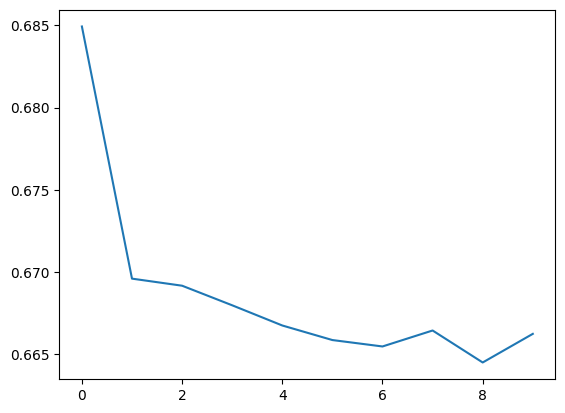

In [13]:
plt.figure(0)
plt.plot(range(epochs), list_epoch_loss)
plt.show()

In [ ]:
import pymol

working_dir = os.getcwd()

def visualize_prediction(y_pred, dataset):
      idx = 0
      for mask_type, num_nodes, protein_path, labels_path in zip(dataset.list_mask_type, dataset.list_num_nodes, dataset.list_protein_path, dataset.list_labels_path):
            if mask_type == 2:

                  b_factors_pred = list(y_pred[idx:idx+num_nodes])

                  labels_pred_path = f"{os.path.splitext(labels_path)[0]}_pred.npy"
                  np.save(os.path.join(working_dir, labels_pred_path), b_factors_pred)

                  pymol.cmd.load(os.path.join(working_dir, protein_path))
                  pymol.cmd.alter('all', "b=-1.00")
                  for index, b in enumerate(b_factors_pred):	
                        pymol.cmd.alter(f'index {index+1}', f'b={float(b)}')

                  protein_pred_path = f"{os.path.splitext(protein_path)[0]}_pred.pdb"
                  pymol.cmd.save(os.path.join(working_dir, protein_pred_path), 'all')
                  pymol.cmd.delete('all')

                  print(labels_pred_path)
                  print(protein_pred_path)
                  
            idx += num_nodes
            
# visualize predictions
visualize_prediction(y_pred, dataset)


In [8]:
import csv
import os

graph_path_list = []
with open("data/processed/data_paths.csv") as f:
    for row in f:
        protein_id = row.split(',')[1]
        graph_id = f"{protein_id}_graph.pyg"

        if os.path.exists(f"data/processed/{protein_id}/{graph_id}"):
            graph_path_list.append(f"data/processed/{protein_id}/{graph_id}")

graph_path_list = graph_path_list[0:3]
print(graph_path_list)

['data/processed/4D7D_A/4D7D_A_graph.pyg', 'data/processed/1FAV_C/1FAV_C_graph.pyg', 'data/processed/8A1P_B/8A1P_B_graph.pyg', 'data/processed/4R5M_A/4R5M_A_graph.pyg', 'data/processed/1QZ9_A/1QZ9_A_graph.pyg', 'data/processed/6A2W_A/6A2W_A_graph.pyg', 'data/processed/3U9S_I/3U9S_I_graph.pyg', 'data/processed/7B7R_A/7B7R_A_graph.pyg', 'data/processed/5H8Q_B/5H8Q_B_graph.pyg', 'data/processed/7XUJ_A/7XUJ_A_graph.pyg', 'data/processed/1R55_A/1R55_A_graph.pyg', 'data/processed/4NG3_A/4NG3_A_graph.pyg', 'data/processed/3NA0_A/3NA0_A_graph.pyg', 'data/processed/1ZKL_A/1ZKL_A_graph.pyg', 'data/processed/1FCA_A/1FCA_A_graph.pyg', 'data/processed/6GHM_A/6GHM_A_graph.pyg', 'data/processed/1YSG_A/1YSG_A_graph.pyg', 'data/processed/7XNL_A/7XNL_A_graph.pyg', 'data/processed/3BQZ_A/3BQZ_A_graph.pyg']
